In [18]:
import sys
sys.path.append("../")

import numpy as np
import ROOT
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import multiprocessing as mp

# 11k test files
sort_dir = "./neutrinos/sorted"
rtd_dir = "./neutrinos/rtd"
src_dir = "./neutrinos/raw"

ROOT.EnableImplicitMT()

### Files Setup

In [19]:
%load_ext autoreload
%autoreload 2
from neutrinoAna import getFiles, UpdateSrc
rtd_files = getFiles(rtd_dir)
sort_files = getFiles(sort_dir)
src_files = getFiles(src_dir)
nBins = int(np.sqrt(len(rtd_files)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# idf = pd.read_csv('neutrinoAna_tmp.csv')
# idf = UpdateSrc(idf, src_dir)
# idf.to_csv('NeutrinoAna_2k.csv')
idf = pd.read_csv('NeutrinoAna_2k.csv')

In [21]:
# worst tiles
f = idf.nlargest(5, 'tile_resets')['sortFile']
for i in f:
    print('file', i)

file C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_397_x-120_y-320_z-10_seed-420_zaxis-1_sorted.root
file C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_397_x-120_y-320_z-80_seed-420_zaxis-1_sorted.root
file C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_215_x-120_y-320_z-10_seed-420_zaxis-1_sorted.root
file C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_215_x-120_y-320_z-80_seed-420_zaxis-1_sorted.root
file C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_295_x-120_y-320_z-10_seed-420_zaxis-1_sorted.root


#### keys and colors

In [22]:
# pdg numbers, negative are anti-particles
# e–	11
# νe	12
# μ–	13
# νμ	14
# τ–	15
# ντ	16
# τ'–	17
# ντ'	18
lepKEKey = {11:'e', 12:'nu_e', 13:'mu', 14:'nu_mu', 15:'tau', 16:'nu_tau', 17:'tau_p', 18:'nu_tau_p'}
lepColors = {11:'red', 12:'green', 13:'blue', 14:'orange', 15:'yellow', 16:'purple', 17:'black', 18:'black'}

### Hist Setup

        energy_deposit   tile_resets         lepKE
lepPdg                                            
-14.0        23.947350    554.785714   7321.265137
-13.0        49.371876   2109.100000   4739.959082
-11.0       167.898342  35695.833333  17999.343750
 11.0        97.140657  10263.333333   3783.929138
 12.0         0.000000      0.000000    888.512024
 13.0        55.456562   1826.930180   2696.387195
 14.0        32.221888    821.597786   2849.420397
energy dep cov of to tile resets 0.9425127560133093


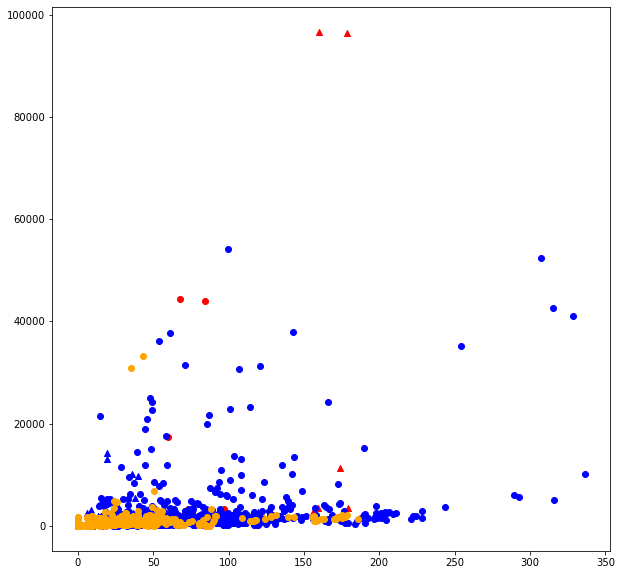

In [23]:
df = idf
grps = df.groupby(['lepPdg'])
pdg_means = grps.mean()
fig, ax = plt.subplots(1, figsize=(10,10))
for name, grp in grps:
    ax.scatter(x=grp["energy_deposit"], y=grp["tile_resets"], c=lepColors.get(abs(name), 'black'), marker='o' if name>0 else '^')

print(pdg_means[['energy_deposit', 'tile_resets', 'lepKE']])
print('energy dep cov of to tile resets', pdg_means['energy_deposit'].corr(pdg_means['tile_resets']))

median total resets: 3022.0
median tile resets: 710.5
median e deposit: 35.79657053405348
found pdgs: [ 14.  13. -13.  11.  12. -14.]


array([<AxesSubplot:title={'center':'muonReco'}>], dtype=object)

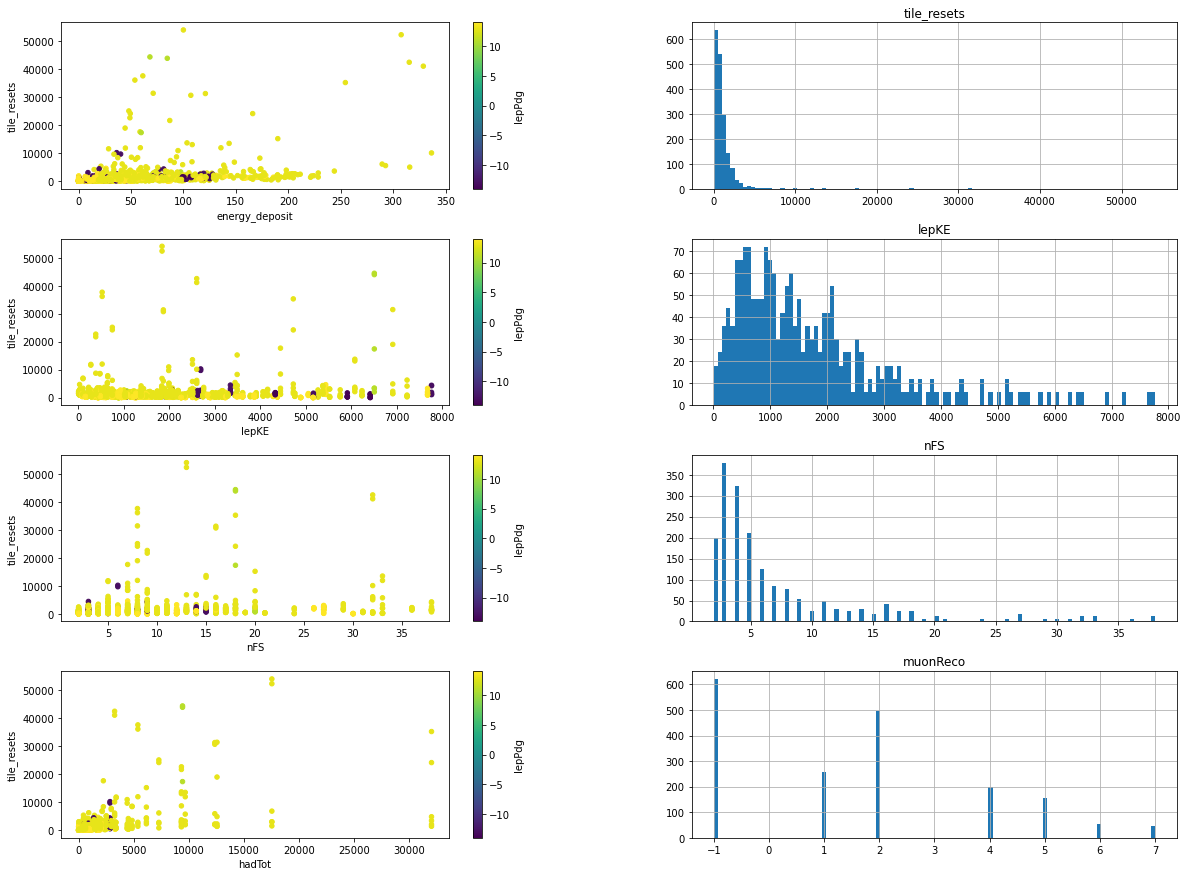

In [24]:
# filters
df = idf[idf['lepKE'] < 8000]
v = df['total_resets'].median()
print('median total resets:', v)
v = df['tile_resets'].median()
print('median tile resets:', v)
v = df['energy_deposit'].median()
print('median e deposit:', v)

pdgs = df['lepPdg'].unique()
print('found pdgs:', pdgs)

#define subplot layout
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,15))
df.plot.scatter(x='energy_deposit', y='tile_resets', c="lepPdg", cmap='viridis', ax=axes[0][0])
df.plot.scatter(x='lepKE', y='tile_resets',  c="lepPdg", cmap='viridis', ax=axes[1][0])
df.hist('tile_resets', bins=nBins, ax=axes[0][1])
df.hist('lepKE', bins=nBins, ax=axes[1][1])
df.plot.scatter(x='nFS', y='tile_resets',  c="lepPdg", cmap='viridis', ax=axes[2][0])
df.hist('nFS', bins=nBins, ax=axes[2][1])
df.plot.scatter(x='hadTot', y='tile_resets',  c="lepPdg", cmap='viridis', ax=axes[3][0])
df.hist('muonReco', bins=nBins, ax=axes[3][1])

In [25]:
cols1 = ['tile_resets', 'nFS', 'lepPdg', 'energy_deposit']
cols = ['lepKE', 'nFS', 'total_resets', 'hadTot', 'energy_deposit']
for col1 in cols1:
    for col2 in cols:
        corr = df[col1].corr(df[col2])
        print ("Correlation between ", col1, " and ", col2, "is: ", round(corr, 2))

Correlation between  tile_resets  and  lepKE is:  0.12
Correlation between  tile_resets  and  nFS is:  0.21
Correlation between  tile_resets  and  total_resets is:  0.72
Correlation between  tile_resets  and  hadTot is:  0.51
Correlation between  tile_resets  and  energy_deposit is:  0.33
Correlation between  nFS  and  lepKE is:  0.03
Correlation between  nFS  and  nFS is:  1.0
Correlation between  nFS  and  total_resets is:  0.26
Correlation between  nFS  and  hadTot is:  0.24
Correlation between  nFS  and  energy_deposit is:  0.81
Correlation between  lepPdg  and  lepKE is:  -0.27
Correlation between  lepPdg  and  nFS is:  0.02
Correlation between  lepPdg  and  total_resets is:  -0.01
Correlation between  lepPdg  and  hadTot is:  0.01
Correlation between  lepPdg  and  energy_deposit is:  -0.02
Correlation between  energy_deposit  and  lepKE is:  0.08
Correlation between  energy_deposit  and  nFS is:  0.81
Correlation between  energy_deposit  and  total_resets is:  0.37
Correlation be

### High reset files

In [26]:
# max energy deposit is not the same as the max reset count
max_reset = df.loc[df['total_resets'].idxmax()]['sortFile']
max_reset_rtd = df.loc[df['total_resets'].idxmax()]['rtdFile']
max_energy_deposit = df.loc[df['energy_deposit'].idxmax()]['sortFile']
max_total_resets = df.loc[df['total_resets'].idxmax()]['sortFile']
print(f"max reset file: {max_reset}")
print(f"max e deposit file {max_energy_deposit}")
print(f"max total reset file {max_total_resets}")

max reset file: C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_175_x-120_y-320_z-80_seed-420_zaxis-1_sorted.root
max e deposit file C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_36_x-120_y-320_z-320_seed-420_zaxis-1_sorted.root
max total reset file C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_175_x-120_y-320_z-80_seed-420_zaxis-1_sorted.root


#### get the ttree of the max rdf file, and show what the hits look like

In [27]:
def findSorted(sorted_file):
    import os
    if os.name != 'nt':
        sorted_file = sorted_file.replace("\\", "/")
        sorted_file = sorted_file.replace("C:", "/mnt/c")
    return sorted_file

In [28]:
def viewEvent(sorted_file, cvname="c", canvas=None):
    """
    take an input sorted file, and draw the neutrino event
    """
    sorted_file = findSorted(sorted_file)
    tf = ROOT.TFile(sorted_file, "READ")
    tt = tf.event_tree
    if canvas is None:
        c = ROOT.TCanvas(cvname, cvname, 500, 500)
    if hasattr(tt, 'hit_start_x'):
        tt.Draw("hit_start_x:hit_start_y:hit_start_z")
    else:
        print('WARNING tree does not have hit branches')
    if canvas is None:
        c.Draw()
        return c
    else:
        return canvas

In [29]:
def viewTileResets(rtd_file, cvname="c", canvas=None):
    """
    view a colz of the reset resets on the tile from the rtd file
    """
    rtd_file = findSorted(rtd_file)
    tf = ROOT.TFile(rtd_file, "READ")
    tt = tf.event_tree
    if canvas is None:
        c = ROOT.TCanvas(cvname, cvname, 500, 500)
    if hasattr(tt, 'pixel_reset'):
        # tt.Draw(f"pixel_x:pixel_y>>{cvname}(1500,1,1500,575,1,575)", "", "colz")
        # h = getattr(ROOT, f"{cvname}")
        # print(h.GetMean())
        xpos = int(120/0.4)
        ypos = int(320/0.4)
        cut = f"pixel_x < {xpos} + 40 && pixel_x > {xpos} - 40 && pixel_y < {ypos} + 40 && pixel_y > {ypos} - 40 "
        tt.Draw(f"pixel_x:pixel_y", f"", "colz")
        return canvas
    else:
        print('WARNING tree does not have hit branches')
        return canvas
    if canvas is None:
        c.Draw()
        return c
    else:
        return canvas

In [30]:
def viewProcesses(sorted_file, cvname="c", canvas=None):
    sorted_file = findSorted(sorted_file)
    tf = ROOT.TFile(sorted_file, "READ")
    tt = tf.event_tree
    if canvas is None:
        c = ROOT.TCanvas(cvname, cvname, 500, 500)
    if hasattr(tt, 'hit_process_key'):
        tt.Draw("hit_process_key")
    else:
        print('WARNING tree does not have hit process branch')
    if canvas is None:
        c.Draw()
        return c
    else:
        return canvas

looking in file: C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\sorted\FHC_100_x-120_y-320_z-10_seed-420_zaxis-0_sorted.root
looking for rtd at C:\Users\keefe\OneDrive\Documents\qpix-digital\simulation-rtd\hits\neutrinos\rtd\FHC_100_x-120_y-320_z-10_seed-420_zaxis-1_sorted_rtd.root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


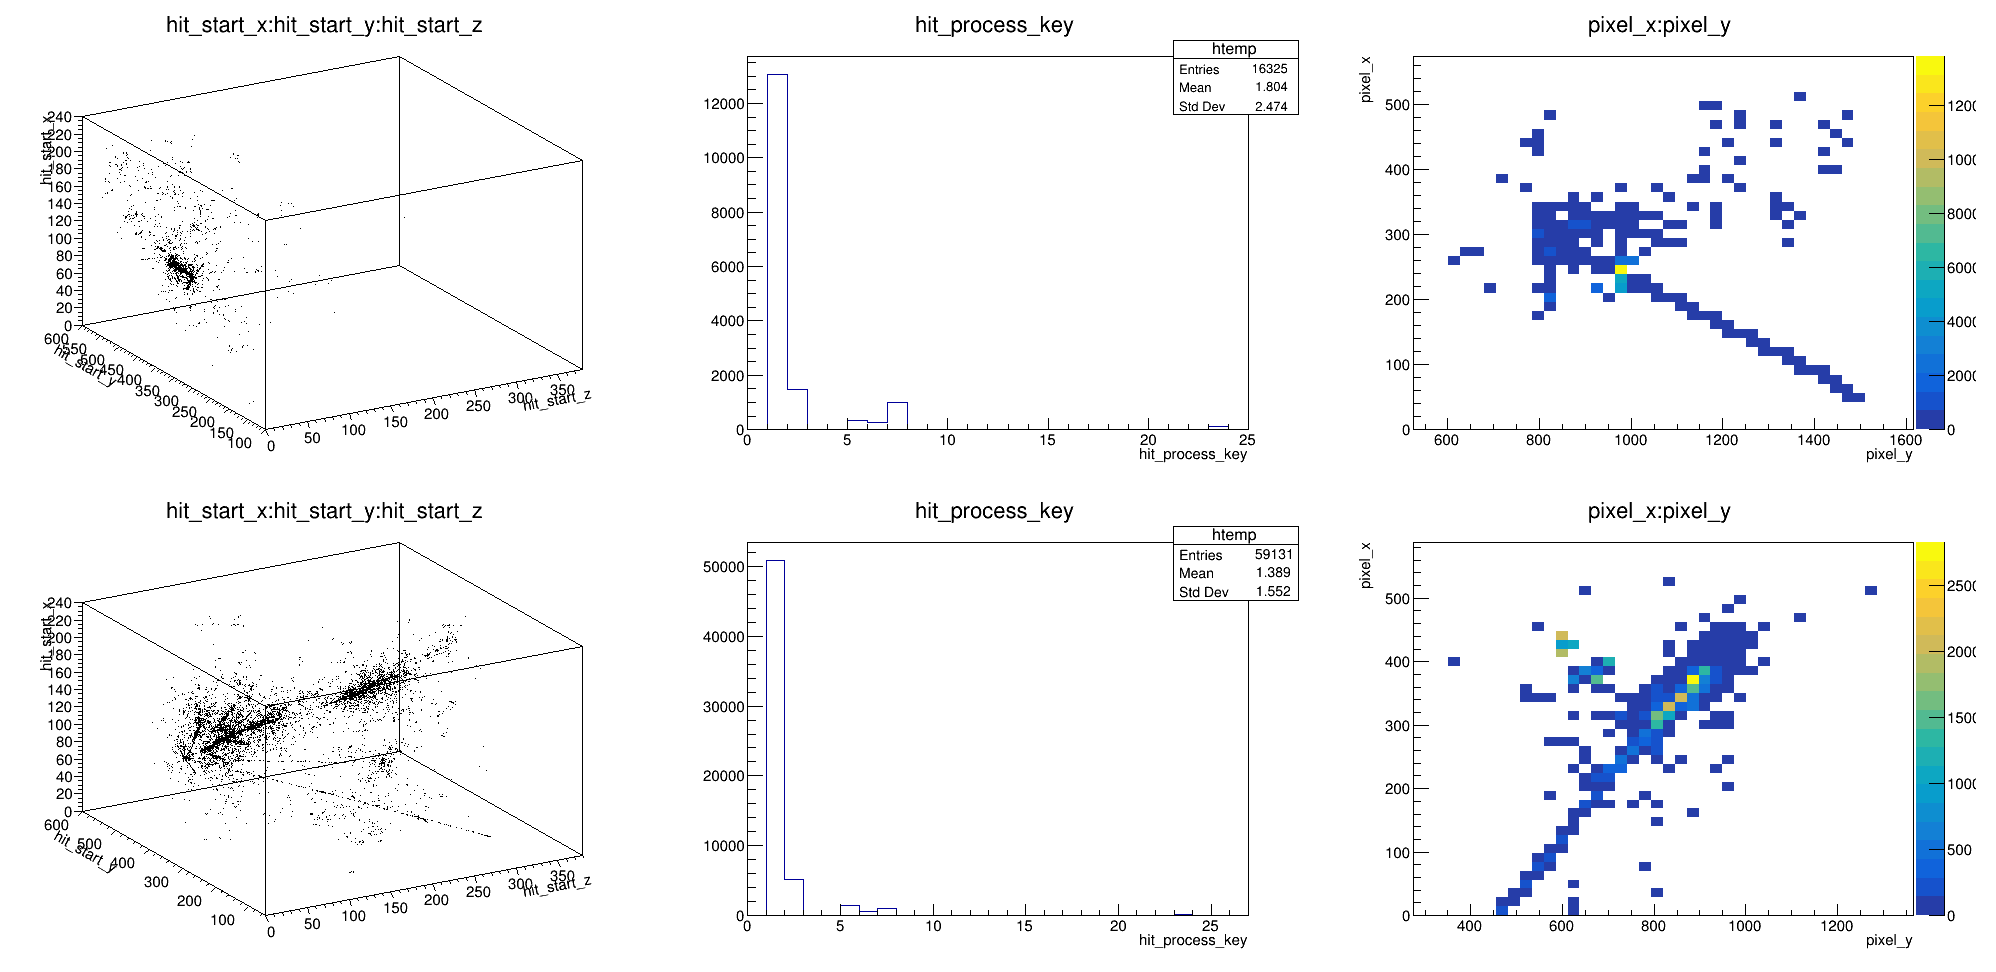

In [46]:
id = 1994
# max_reset = df.loc[df['total_resets'].idxmax()]['sortFile']
# max_reset_rtd = df.loc[df['total_resets'].idxmax()]['rtdFile']
max_reset = df['sortFile'][id]
max_reset_rtd = df['rtdFile'][id]
print(f"looking in file: {max_reset}")
## verify that the rotation angle works
canv = ROOT.TCanvas("canv", "canv" , 2000, 1000)
canv.Divide(3,2)
canv.cd(1)
f = viewEvent(max_reset, "f", canv)
canv.cd(2)
e = viewProcesses(max_reset, "e", canv)
canv.cd(3)
a = viewTileResets(max_reset_rtd, "a", canv)
if 'zaxis-1' in max_reset:
    swap_reset = max_reset.replace("zaxis-1", "zaxis-0")
    swap_rtd = max_reset_rtd.replace("zaxis-1", "zaxis-0")
else:
    swap_reset = max_reset.replace("zaxis-0", "zaxis-1")
    swap_rtd = max_reset_rtd.replace("zaxis-0", "zaxis-1")
print("looking for rtd at", swap_rtd)
canv.cd(4)
g = viewEvent(swap_reset, "f", canv)
canv.cd(5)
h = viewProcesses(swap_reset, "e", canv)
canv.cd(6)
b = viewTileResets(swap_rtd, "b", canv)
canv.Draw()

### Visual full csv

#### boxplot

[]

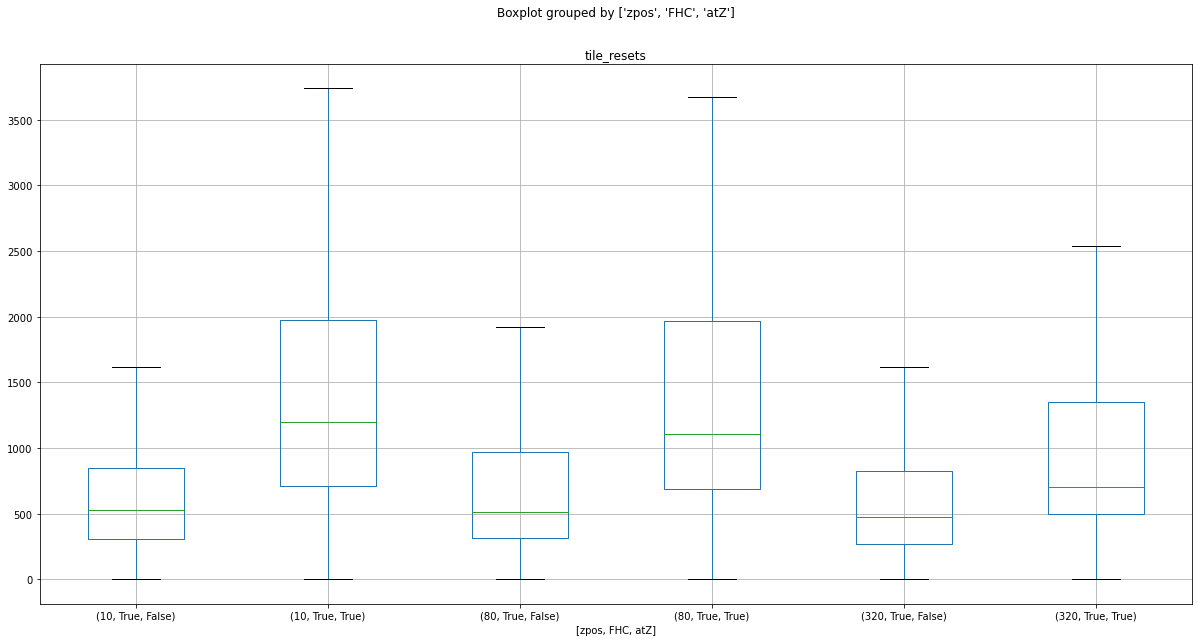

In [32]:
cdf = df
a = cdf.boxplot('tile_resets', by=['zpos','FHC','atZ'], sym="", figsize=(20,10))
a.plot()

#### scatter and means

In [33]:
cdf = df.groupby(['zpos', 'FHC', 'atZ'])
means = cdf.mean()
stds = cdf.std()
ind = means.index
ndf = pd.DataFrame()
zs = sorted(df['zpos'].unique())

print(means['tile_resets'].head)

plot_data = [ [], [], [], [] ]
plot_err = [ [], [], [], [] ]
names = ["RHC", "FHC", "RHC-Z", "FHC-Z"]

# for i in ind:
#     id = int(i[1])+2*int(i[2])
#     plot_data[id].append(means.loc[i]['tile_resets'])
#     plot_err[id].append(stds.loc[i]['tile_resets'])

# for i in range(4):
#     plt.plot(zs, plot_data[i], label=f"{names[i]}")
# plt.legend()  
# df.plot('zpos', 'total_resets', kind='scatter')

<bound method NDFrame.head of zpos  FHC   atZ  
10    True  False     717.287582
            True     2635.065359
80    True  False     719.855738
            True     2590.055738
320   True  False     665.118033
            True     1192.167213
Name: tile_resets, dtype: float64>
